In [1]:
import numpy as np
import cv2
from skimage.segmentation import clear_border
import matplotlib.pyplot as plt

from bubblekicker.bubblekicker import (BubbleKicker, batchbubblekicker, bubble_properties_calculate, 
                                       _bubble_properties_filter, bubble_properties_plot)

from bubblekicker.pipelines import CannyPipeline, AdaptiveThresholdPipeline
import matplotlib
from matplotlib import pyplot as plt
import os
import seaborn as sns
import sys
%matplotlib inline

In [2]:
img = cv2.imread('C:\Users\Serena\Desktop\campione20mL.jpg',-1)

In [3]:
img_B,img_G,img_R = cv2.split(img)

In [4]:
img2 = cv2.merge((img_R,img_G,img_B))

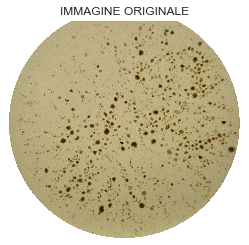

In [5]:
plt.imshow(img2), plt.grid('off'), plt.xticks([]), plt.yticks([]), plt.title('IMMAGINE ORIGINALE'); 
plt.savefig('C:\Users\Serena\Desktop\OriginalRGB.jpg',dpi=500)

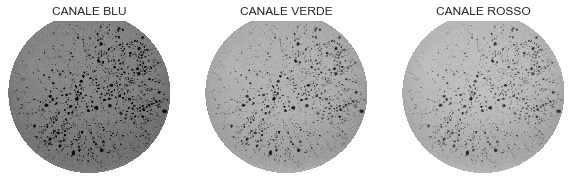

In [6]:
plt.figure(figsize=(10, 10))
plt.subplot(3,3,1),plt.imshow(img_B, cmap='gray'), plt.title('CANALE BLU'), plt.xticks([]), plt.yticks([]); 
plt.subplot(3,3,2), plt.imshow(img_G, cmap='gray'), plt.title('CANALE VERDE'), plt.xticks([]), plt.yticks([]); 
plt.subplot(3,3,3), plt.imshow(img_R, cmap='gray'), plt.title('CANALE ROSSO'), plt.xticks([]), plt.yticks([]); 
plt.savefig('C:\Users\Serena\Desktop\channels.jpg',dpi=500)

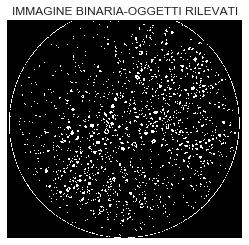

In [8]:
binImg = cv2.adaptiveThreshold(img_G, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 91,18)
plt.imshow(binImg), plt.title('IMMAGINE BINARIA-OGGETTI RILEVATI'), plt.xticks([]), plt.yticks([]);  
plt.savefig('C:\Users\Serena\Desktop\oggetti_rilevati.jpg',dpi=500)

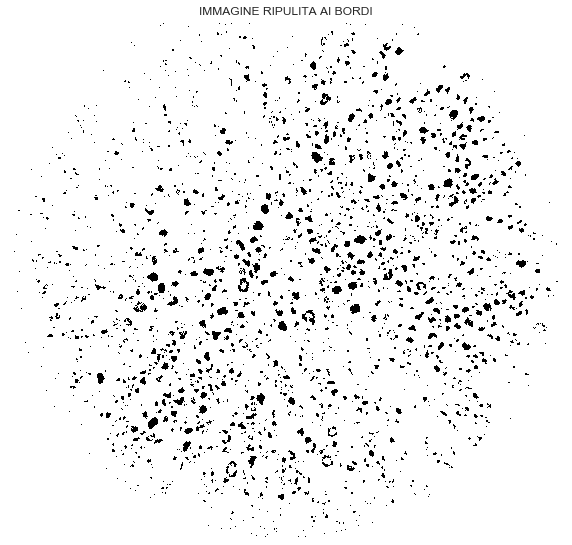

In [9]:
dst_inv = cv2.bitwise_not(binImg) 
img_clb = clear_border(dst_inv, buffer_size=5, bgval=1)
plt.figure(figsize=(10,10))
plt.imshow(img_clb), plt.title('IMMAGINE RIPULITA AI BORDI'), plt.grid('off'), plt.xticks([]), plt.yticks([]);
plt.savefig('C:\Users\Serena\Desktop\IMMAGINE RIPULITA AI BORDI.jpg', dpi=500)

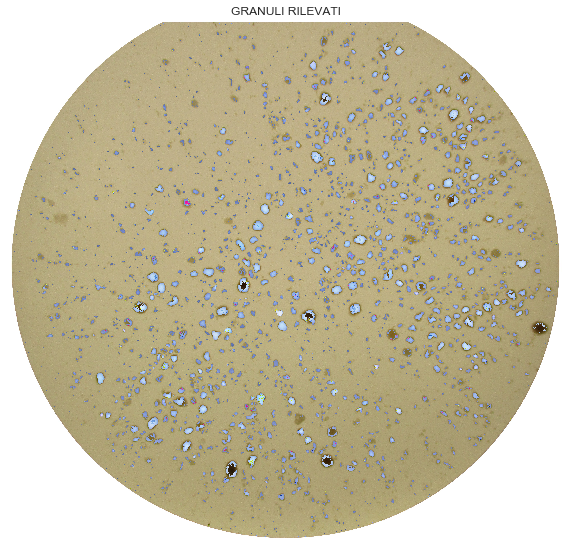

In [10]:
img_outl = cv2.merge((img_R * img_clb, img_G * img_clb, img_B * img_clb))
plt.figure(figsize=(10, 10));
plt.imshow(img_G * img_clb), plt.title('GRANULI RILEVATI'), plt.xticks([]), plt.yticks([])
plt.imshow(img_outl), plt.title('GRANULI RILEVATI'), plt.grid('off'), plt.xticks([]), plt.yticks([]);
plt.savefig('C:\Users\Serena\Desktop\GRANULI_RILEVATI.jpg',dpi=500)

In [11]:
marker_image, props = bubble_properties_calculate(img_clb,rules={'convexity': {'min':1.9 }, 'circularity_reciprocal': {'max': 2.8, 'min': 0.2}});



{'max': 2.8, 'min': 0.2}
{'min': 1.9}


In [12]:
props.head()

,area,centroid,convex_area,equivalent_diameter,perimeter,convexity,circularity_reciprocal
label,,,,,,,
274,79,"(79.6455696203, 1571.34177215)",92,10.029253,39.798990,1.984975,1.595538
284,200,"(88.935, 1509.14)",255,15.957691,70.941125,2.819239,2.002425
285,420,"(91.0833333333, 2476.74285714)",493,23.124892,98.012193,4.285181,1.820124
302,118,"(98.3220338983, 1376.3220339)",136,12.257335,42.006097,2.809116,1.189961
303,101,"(96.8514851485, 2937.40594059)",136,11.340070,50.455844,2.001750,2.005819


In [13]:
props['equivalent_diameter_mm']=props['equivalent_diameter']/49

props.head()

,area,centroid,convex_area,equivalent_diameter,perimeter,convexity,circularity_reciprocal,equivalent_diameter_mm
label,,,,,,,,
274,79,"(79.6455696203, 1571.34177215)",92,10.029253,39.798990,1.984975,1.595538,0.204679
284,200,"(88.935, 1509.14)",255,15.957691,70.941125,2.819239,2.002425,0.325667
285,420,"(91.0833333333, 2476.74285714)",493,23.124892,98.012193,4.285181,1.820124,0.471937
302,118,"(98.3220338983, 1376.3220339)",136,12.257335,42.006097,2.809116,1.189961,0.250150
303,101,"(96.8514851485, 2937.40594059)",136,11.340070,50.455844,2.001750,2.005819,0.231430


In [14]:
def classe(equivalent_diameter_mm):
    if equivalent_diameter_mm>= 1:
        return 5 
    elif 0.8<=equivalent_diameter_mm<1:
        return 4
    elif 0.5<=equivalent_diameter_mm<0.8:
        return 3
    elif 0.2<=equivalent_diameter_mm<0.5:
        return 2
    elif equivalent_diameter_mm<0.2:
        return 1
    

In [15]:
props["equivalent_diameter_mm"].apply(classe);


In [16]:
props['classe']=props["equivalent_diameter_mm"].apply(classe)
props.head()

,area,centroid,convex_area,equivalent_diameter,perimeter,convexity,circularity_reciprocal,equivalent_diameter_mm,classe
label,,,,,,,,,
274,79,"(79.6455696203, 1571.34177215)",92,10.029253,39.798990,1.984975,1.595538,0.204679,2
284,200,"(88.935, 1509.14)",255,15.957691,70.941125,2.819239,2.002425,0.325667,2
285,420,"(91.0833333333, 2476.74285714)",493,23.124892,98.012193,4.285181,1.820124,0.471937,2
302,118,"(98.3220338983, 1376.3220339)",136,12.257335,42.006097,2.809116,1.189961,0.250150,2
303,101,"(96.8514851485, 2937.40594059)",136,11.340070,50.455844,2.001750,2.005819,0.231430,2


In [17]:
classi=props["equivalent_diameter_mm"].apply(classe)


In [18]:
[1 for i in classi if i==1]
print('classe 1')
len( [1 for i in classi if i==1])

classe 1


50

In [19]:
[2 for i in classi if i==2] 
print('classe 2')
len([2 for i in classi if i==2]  )

classe 2


679

In [20]:
[3 for i in classi if i==3] 
print('classe 3')
len([3 for i in classi if i==3] )

classe 3


208

In [21]:
[4 for i in classi if i==4]
print('classe 4')
len([4 for i in classi if i==4])

classe 4


71

In [22]:
[5 for i in classi if i==5]
print('classe 5')
len([5 for i in classi if i==5])


classe 5


24

In [179]:
len(classi)

5

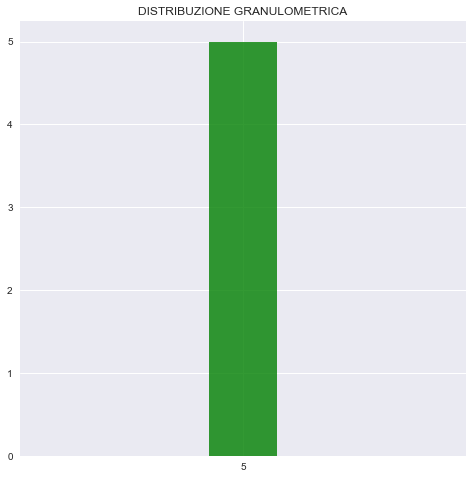

In [180]:
fig = plt.figure(figsize=(8,8));
plt.xticks([k for k in range(0,7)]);
classi.hist(bins=5, rwidth=0.8, color='green', align='mid', alpha=0.8); #rwidth =spessore barra #non riesco a mettere il numero al centro della barra

plt.grid('on'),plt.title('DISTRIBUZIONE GRANULOMETRICA')
plt.savefig('C:\Users\Serena\Desktop\distribuzione_granulometrica.jpg',dpi=500)

In [139]:
#fig = plt.figure(figsize=(10,10))
#sns.pairplot(props)#prendi solo l'immagine che ti interessa...l'ultima



In [140]:
#ax = plt.subplot(111) # crei un'area di plotting
#ax.set_xticks(range(10)) # l'asse x va da 0 a 10
#ax.set_yticks(range(10)) #l'asse y va da 0 a 10


In [181]:
rect = [props.centroid] 
rect


[label
 2     (73.8673445535, 76.9957924264)
 13    (147.989336327, 312.694822506)
 32    (269.282573169, 678.466349725)
 72    (406.717850851, 384.571197886)
 96     (710.634753212, 305.40581474)
 Name: centroid, dtype: object]

In [149]:
rect=[49.7609561753, 1916.57768924]
#plt.plot([1,2,3]);
#plt.axis([-1.1, 1.1, -1.1, 1.1]) ;
# plt.xticks([0.25*k for k in range(-4,5)]) ;
#plt.yticks([-0.9, -0.4, 0.0, 0.3, 0.6, 0.85],['A','B','C','D','E','F']);
#plt.title('The cubic function in [-1,1]')
#plt.xlabel('my x-axis label')
#plt.ylabel('my y-axis label')
#plt.grid()
#x=1,2,3
#y=3,2,4
#plt.plot(x,y,'g:o');

In [148]:
#x=185.968253968,407.153994845
#y=#.55026455,385.184439433
#plt.plot(x,y,'g:o');